# Explore the relationship between hospitalization duration and diagnosis codes

In [1]:
import sys
sys.path.append("/home/wanxinli/deep_patient/")

from ast import literal_eval
from common import *
from mimic_common import *
from multiprocess import Pool
import os
import random
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import time


/home/wanxinli/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
output_dir = os.path.join(os.path.expanduser("~"), f"deep_patient/outputs/mimic")
print(f"Will save outputs to {output_dir}")

Will save outputs to /home/wanxinli/deep_patient/outputs/mimic


In [3]:
""" 
Read in the original dataframe
"""
admid_diagnosis_df = pd.read_csv("../../outputs/mimic/ADMID_DIAGNOSIS.csv", index_col=0, header=0, converters={'ICD codes': literal_eval})
print(admid_diagnosis_df)

""" 
Print number of patients for each category
"""
print("female:", admid_diagnosis_df.loc[(admid_diagnosis_df['gender'] == 'F')].shape[0])
print("male:", admid_diagnosis_df.loc[(admid_diagnosis_df['gender'] == 'M')].shape[0])


         adm_type gender                                          ICD codes  \
admid                                                                         
172335  EMERGENCY      F  [403.01, 486, 582.81, 585.5, 425.4, 276.2, 710...   
173633  EMERGENCY      F  [403.01, 585.6, 583.81, 710.0, 558.9, 287.5, 2...   
174105  EMERGENCY      M               [531.00, 410.71, 285.9, 414.01, 725]   
109976  EMERGENCY      M                             [191.5, 331.4, 530.81]   
178393   ELECTIVE      M       [414.01, 411.1, 482.83, 285.9, 272.0, 305.1]   
...           ...    ...                                                ...   
172304   ELECTIVE      F       [202.80, 348.5, 784.3, 401.9, 272.0, 530.81]   
152542  EMERGENCY      M  [566, 250.62, 357.2, V58.67, 427.31, 401.9, 42...   
161999  EMERGENCY      M  [434.11, 348.5, 348.4, 430, 348.30, 997.31, 51...   
189314  EMERGENCY      F  [346.80, 784.3, 745.5, 781.94, 368.40, 781.3, ...   
168949  EMERGENCY      M  [052.9, 416.2, 201.92, 135

In [4]:
"""
Train deep patient model and generate representations for targets and sources
"""

def custom_train_reps(target_features, source_features, n_components, pca_explain=False):
    """ 
    Customized training algorithm for generating target representations and source representations

    :param bool pca_explain: print the explained variance of each components
    
    :returns: target representations, source representations
    """
    source_pca = PCA(n_components=n_components)
    target_pca = PCA(n_components=n_components)
    target_reps = target_pca.fit_transform(target_features)
    source_reps = source_pca.fit_transform(source_features)

    if pca_explain:
        source_exp_var = source_pca.explained_variance_ratio_
        source_cum_sum_var = np.cumsum(source_exp_var)
        target_exp_var = target_pca.explained_variance_ratio_
        target_cum_sum_var = np.cumsum(target_exp_var)
        print("Cummulative variance explained by the source PCA is:", source_cum_sum_var[-1])
        print("Cummulative variance explained by the target PCA is:", target_cum_sum_var[-1])

    return target_reps, source_reps

In [5]:
n_components = 50
model_func = linear_model.LinearRegression
entire_proc_cts(n_components, admid_diagnosis_df, custom_train_reps, model_func, male_count = 120, female_count = 100, pca_explain=True)

Cummulative variance explained by the source PCA is: 0.7678876266986097
Cummulative variance explained by the target PCA is: 0.8032765868009224


(329688.1247350753,
 461449.104417741,
 830085.5407162404,
 1275690.576246949,
 761840.4463242984,
 1184237.3845959392)

Run one iteration using Linear regression

Study the admission map

In [6]:

""" 
Obtain the female count by male count coupling
"""

model_func = linear_model.LinearRegression
# model_func=  linear_model.PoissonRegressor
male_count = 120
female_count = 100
selected_df = select_df_cts(admid_diagnosis_df, male_count=male_count, female_count=female_count)
selected_df = selected_df.drop(columns=['adm_type', 'diagnosis', 'label'])
selected_df_male = selected_df[selected_df['gender']=='M']
selected_df_female = selected_df[selected_df['gender']=='F']
selected_df_male.to_csv(os.path.join(output_dir, "selected_df_male.csv"), header=True, index=True)
selected_df_female.to_csv(os.path.join(output_dir, "selected_df_female.csv"), header=True, index=True)

source_features, source_labels, target_features, target_labels = gen_features_duration(selected_df)

target_reps, source_reps = custom_train_reps(target_features, source_features, n_components)
np.savetxt(os.path.join(output_dir, "target_reps.txt"), target_reps)
np.savetxt(os.path.join(output_dir, "source_reps.txt"), source_reps)


ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1, max_iter=100000)
ot_sinkhorn.fit(Xs=target_reps, Xt=source_reps)
trans_target_reps = ot_sinkhorn.transform(Xs=target_reps)




In [7]:
def calc_stats(source_reps, source_labels, target_reps, target_labels, \
    trans_target_reps, model_func): 
    # fit the model
    source_model = model_func()
    source_model.fit(source_reps, source_labels)

    # calculate the stats
    source_pred_labels = source_model.predict(source_reps)
    # source_mae = [metrics.mean_absolute_error(i, j) for i, j in zip(source_labels, source_pred_labels)]
    # source_mse = metrics.mean_squared_error(source_labels, source_pred_labels)
    # source_rmse = np.sqrt(metrics.mean_squared_error(source_labels, source_pred_labels))

    target_pred_labels = source_model.predict(target_reps)
    target_mae = [abs(i-j) for i, j in zip(target_labels, target_pred_labels)]
    # target_mse = metrics.mean_squared_error(target_labels, target_pred_labels)
    # target_rmse = np.sqrt(metrics.mean_squared_error(target_labels, target_pred_labels))

    trans_target_pred_labels = source_model.predict(trans_target_reps)
    trans_target_mae = [abs(i-j) for i, j in zip(target_labels, trans_target_pred_labels)]
    # trans_target_mse = [metrics.mean_squared_error(i, j) for i, j in zip(target_labels, trans_target_pred_labels)]
    # trans_target_rmse =  [np.sqrt(metrics.mean_squared_error(i, j)) for i, j in zip(target_labels, trans_target_pred_labels)]
    return target_mae, trans_target_mae

In [8]:
target_maes, trans_target_maes = calc_stats(source_reps, source_labels, target_reps, target_labels, \
    trans_target_reps, linear_model.LinearRegression)

print(trans_target_reps.shape)
selected_df_female['target_ae'] = target_maes
selected_df_female['trans_target_ae'] = trans_target_maes
selected_df_female['ae_ratio'] = [(i-j)/j for i, j in zip(trans_target_maes, target_maes)]
selected_df_female

(100, 50)


/tmp/ipykernel_2665692/4153930218.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df_female['target_ae'] = target_maes
/tmp/ipykernel_2665692/4153930218.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df_female['trans_target_ae'] = trans_target_maes
/tmp/ipykernel_2665692/4153930218.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

,gender,ICD codes,duration,target_ae,trans_target_ae,ae_ratio
admid,,,,,,
145439,F,"[414.01, 411.1, 135, 517.8, 401.9, 272.0, 285....",687840.0,9.618279e+05,778596.943174,-0.190503
194220,F,"[562.12, 599.0, 493.20, 276.2, 285.1, 518.83, ...",650040.0,1.649539e+05,222667.341013,0.349876
196044,F,"[441.2, 746.4, 285.9, 401.9]",622800.0,8.636003e+04,146614.746206,0.697715
147964,F,"[535.50, 935.1, 428.0, E915, E849.0, 401.9, 24...",352740.0,1.758527e+06,352711.300588,-0.799428
136471,F,"[V30.00, V29.0, V05.3, 757.33]",156240.0,1.168475e+06,562700.416392,-0.518432
...,...,...,...,...,...,...
182472,F,"[801.11, 348.5, 801.21, 319, 343.9, 345.90, 81...",483240.0,3.826856e+05,915090.774196,1.391234
105151,F,"[150.5, 518.0, 511.9, 278.00, 401.9]",795240.0,2.180844e+03,167039.386046,75.593918
128213,F,"[348.4, 336.0]",190800.0,1.832372e+04,383915.090162,19.951812


In [9]:
""" 
Study the coupling

Find the most two similar males for each female
"""

max_male_indices = []
max_male_probs = []
for i in range(ot_sinkhorn.coupling_.shape[0]): # for each column
    max_male_indices.append(np.argmax(ot_sinkhorn.coupling_[i, :])+1)
    max_male_probs.append(np.max(ot_sinkhorn.coupling_[i, :]))

print(len(max_male_indices))
print(max_male_indices)
print(max_male_probs)
selected_df_female['max_prob'] = max_male_probs
selected_df_female
selected_df_female.to_csv(os.path.join(output_dir, "selected_df_female.csv"), header=True, index=True)



100
[35, 63, 17, 20, 106, 75, 71, 86, 21, 72, 10, 32, 38, 85, 31, 113, 96, 37, 111, 9, 12, 1, 49, 15, 116, 100, 33, 39, 69, 45, 48, 75, 59, 98, 65, 4, 11, 77, 83, 41, 23, 115, 59, 67, 106, 66, 94, 105, 79, 39, 93, 61, 63, 78, 50, 45, 22, 82, 99, 90, 55, 81, 8, 19, 118, 119, 16, 28, 120, 83, 84, 13, 91, 101, 46, 114, 76, 68, 53, 118, 95, 26, 25, 88, 24, 18, 30, 27, 52, 64, 73, 107, 103, 117, 54, 108, 34, 2, 97, 92]
[0.00717428476210933, 0.002855379762214196, 0.0039059081285485846, 0.0055039361215798365, 0.002063515192920008, 0.0015521004344433537, 0.00803963611602779, 0.006356909751337638, 0.005293389240485575, 0.008322075890083498, 0.0038898987758860873, 0.004741073247378598, 0.004693140477249477, 0.008077975202439452, 0.004308454129861025, 0.008282520585071744, 0.006206867530186863, 0.008333333572867248, 0.008332935127716162, 0.008333314698221577, 0.00544593646611242, 0.004171038338077641, 0.004114727698333773, 0.008291426912637281, 0.007863236918452712, 0.006265227074809576, 0.003941

/tmp/ipykernel_2665692/2993418858.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df_female['max_prob'] = max_male_probs


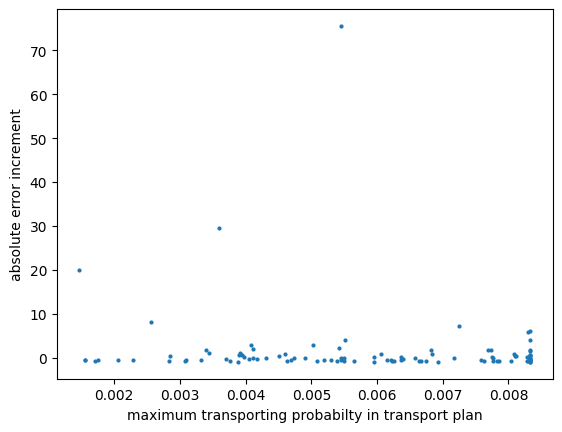

In [10]:
""" 
Plot mae ratio vs max probablity
"""
plt.scatter(list(selected_df_female['max_prob']), list(selected_df_female['ae_ratio']), s=4) 
plt.xlabel('maximum transporting probabilty in transport plan')
plt.ylabel('absolute error increment')
fig_path = os.path.join(output_dir, "exp4_prob.pdf")
plt.savefig(fig_path)
# plt.ylim(-2, 0)

/tmp/ipykernel_2665692/1628527338.py:20: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  ax = sns.heatmap(heatmap_df.pivot('female_index', 'male_index', 'probability'), cmap="Blues")


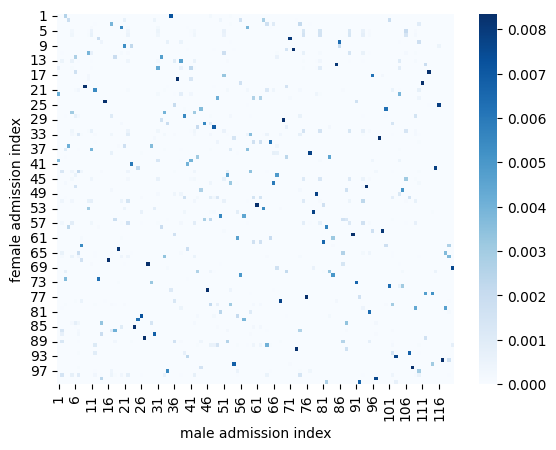

In [11]:
""" 
Match each female with the most likely male by appending the dataframe
"""
selected_df_female = selected_df_female.reset_index(drop=True)
selected_df_male = selected_df_male.reset_index(drop=True)
heatmap_vec = []
thres = 0 # only taking the couplings that exceed thres
coupling_thres = np.zeros(shape=ot_sinkhorn.coupling_.shape)
for i in range(ot_sinkhorn.coupling_.shape[0]): # for each column
    for j in range(ot_sinkhorn.coupling_.shape[1]):
        heatmap_vec.append([i+1, j+1, ot_sinkhorn.coupling_[i][j]])
        if ot_sinkhorn.coupling_[i][j] >= thres:
            coupling_thres[i][j] = ot_sinkhorn.coupling_[i][j]

    # print("count is:", count)
heatmap_df = pd.DataFrame(heatmap_vec, columns=['female_index', 'male_index', 'probability'])

ticksize=10
fig_path = os.path.join(output_dir, "exp4_heatmap.pdf")
ax = sns.heatmap(heatmap_df.pivot('female_index', 'male_index', 'probability'), cmap="Blues")

plt.xlabel("male admission index", fontsize=ticksize)
plt.ylabel("female admission index", fontsize=ticksize)
plt.savefig(fig_path, bbox_inches = 'tight')
plt.show()


In [12]:
# """ 
# Create bipartite graph
# """

# import networkx as nx
# from networkx.algorithms import bipartite
# import scipy.sparse as sparse

# a_matrix = sparse.csc_matrix(coupling_thres)
# edge_colors = []
# for i in range(coupling_thres.shape[0]):
#     for j in range(coupling_thres.shape[1]):
#         if coupling_thres[i][j] != 0:
#                 edge_colors.append(coupling_thres[i][j])


# G = bipartite.from_biadjacency_matrix(a_matrix, create_using=None, 
#                                          edge_attribute='weight')
# u = [n for n in G.nodes if G.nodes[n]['bipartite'] == 0]


# X, Y = bipartite.sets(G, top_nodes=u)
# labels = {}   
# node_colors = [] 
# for node in G.nodes:
#     if node < coupling_thres.shape[0]:
#         labels[node] = node+1
#         node_colors.append('red')
#     else:
#         labels[node] = node+1-coupling_thres.shape[0]
#         node_colors.append('cornflowerblue')

# plt.figure(figsize=(20, 5))
# pos = dict()
# pos.update((n, (i*50, 0)) for i, n in enumerate(X))
# pos.update((n, (i*50, 0.01)) for i, n in enumerate(Y))

# num_edges = G.number_of_edges()
# num_nodes = G.number_of_nodes()

# sc = nx.draw(G, pos, labels=labels,
#         edge_color=edge_colors, 
#         edge_cmap=plt.get_cmap('Greys'),
#         node_color=node_colors,
#         node_size=400)

# # nx.draw(G, with_labels=True)
# # nodes = nx.draw_networkx_nodes(G,pos,node_color=node_colors, node_size=300)
# edges = nx.draw_networkx_edges(G,pos,edge_color=edge_colors,
#                                edge_cmap=plt.cm.Greys)
# cbar = plt.colorbar(edges)
# cbar.set_label(label='transport significance', size=20)
# cbar.ax.tick_params(labelsize=20)

# plt.axis('off')

# # plt.colorbar(sc, label=r'significance')

# fig_path = os.path.join(output_dir, "exp4_network.pdf")
# plt.savefig(fig_path)
# plt.show()

In [13]:
selected_df_female.iloc[1]['ICD codes']

['562.12',
 '599.0',
 '493.20',
 '276.2',
 '285.1',
 '518.83',
 '287.4',
 'V46.11',
 '401.9',
 'V44.0',
 '414.01',
 '412',
 '285.29']

(100, 120)
(100, 120)
[[2.92058391e-22 8.93815017e-14 2.53926291e-03 ... 4.21300851e-70
  1.28696867e-16 6.26898990e-18]
 [2.30164932e-36 2.08180601e-30 1.35997099e-15 ... 4.06338165e-31
  3.01566785e-36 4.14206139e-13]
 [1.35939335e-12 1.07197659e-10 1.32043129e-06 ... 2.08288678e-36
  7.31882203e-15 2.95656026e-08]
 ...
 [1.03668054e-09 1.47030590e-03 9.60158963e-11 ... 4.34417900e-11
  6.16068483e-05 3.22034090e-11]
 [6.54841272e-46 2.19693961e-12 1.80922574e-29 ... 1.37933421e-45
  2.80971542e-65 9.56246117e-26]
 [5.23600687e-69 4.49755265e-53 1.80702735e-25 ... 1.02732962e-06
  1.76661585e-27 7.73132604e-54]]
target_features is: ['414.01', '411.1', '135', '517.8', '401.9', '272.0', '285.9', '433.10', '244.9', '294.8', '250.00']
target_chapters are: [7, 7, 1, 8, 7, 3, 4, 7, 3, 5, 3]
target_features is: ['414.01', '411.1', '135', '517.8', '401.9', '272.0', '285.9', '433.10', '244.9', '294.8', '250.00']
target_chapters are: [7, 7, 1, 8, 7, 3, 4, 7, 3, 5, 3]
target_features is: ['414.

/tmp/ipykernel_2665692/787906737.py:31: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  ax = sns.heatmap(chapter_corr_df.pivot('target_chapter', 'source_chapter', 'density'), cmap="Blues")


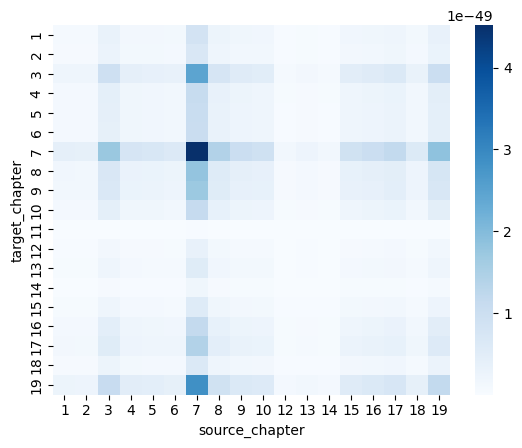

In [14]:
""" 
Create correlation matrix between ICD chapters of males and females
"""
# heatmap_vec = np.array(heatmap_vec)
print(coupling_thres.shape)
print(ot_sinkhorn.coupling_.shape)
print(coupling_thres)
num_chapter = 20
chapter_corr_matrix = np.zeros(shape=[num_chapter, num_chapter])
for target_index in range(coupling_thres.shape[0]):
    for source_index in range(coupling_thres.shape[1]):
        if coupling_thres[i][j] != 0:
            print("coupling_thres is:", coupling_thres[i][j])
            target_features = selected_df_female.iloc[target_index]['ICD codes']
            target_chapters = decide_all_ICD_chapters(target_features)
            print("target_features is:", target_features)
            print("target_chapters are:", target_chapters)
            source_features = selected_df_male.iloc[source_index]['ICD codes']
            source_chapters = decide_all_ICD_chapters(source_features)
            print("source_features is:", source_features)
            print("source_chapters are:", source_chapters)
            for target_chapter in target_chapters:
                for source_chapter in source_chapters:
                    chapter_corr_matrix[target_chapter][source_chapter] += coupling_thres[i][j]
print(chapter_corr_matrix)
chapter_corr_vec = []
for i in range(chapter_corr_matrix.shape[0]):
    for j in range(chapter_corr_matrix.shape[1]):
        if chapter_corr_matrix[i][j] != 0:
            chapter_corr_vec.append([i, j, chapter_corr_matrix[i][j]])

chapter_corr_df = pd.DataFrame(chapter_corr_vec, columns=['target_chapter', 'source_chapter', 'density'])

ax = sns.heatmap(chapter_corr_df.pivot('target_chapter', 'source_chapter', 'density'), cmap="Blues")
plt.show()


In [15]:
chapter_corr_df

,target_chapter,source_chapter,density
0,1,1,7.514849e-51
1,1,2,7.236521e-51
2,1,3,3.200769e-50
3,1,4,1.419471e-50
4,1,5,1.308140e-50
...,...,...,...
337,19,15,5.610623e-50
338,19,16,6.466481e-50
339,19,17,7.417434e-50
340,19,18,3.898908e-50


In [ ]:
heatmap_df 

In [ ]:
""" 
Run multiple iterations using Poisson regression
"""
score_path = os.path.join(output_dir, "exp4_poisson_score_"+str(n_components)+".csv")
male_count = 120
female_count = 100

multi_proc_cts(score_path, n_components, admid_diagnosis_df, custom_train_reps, \
    male_count, female_count, model_func = linear_model.PoissonRegressor, iteration=100)

In [ ]:
# score_path = os.path.join(output_dir, "exp4_poisson_score_"+str(n_components)+".csv")

# save_path = "../../outputs/mimic/exp4_poisson_res.png"
# box_plot_cts_short(score_path, save_path=save_path)


In [ ]:
""" 
Run multiple iterations using linear regression
"""
score_path = os.path.join(output_dir, "exp4_linear_score_"+str(n_components)+".csv")
male_count = 120
female_count = 100

multi_proc_cts(score_path, n_components, admid_diagnosis_df, custom_train_reps, \
    male_count, female_count, model_func = linear_model.LinearRegression, iteration=100)

In [ ]:
# score_path = os.path.join(output_dir, "exp4_linear_score.csv")
# save_path = "../../outputs/mimic/exp4_linear_res.png"

# box_plot_cts_short(score_path, save_path=save_path)

In [ ]:
""" 
Combine plots for MIMIC experiment 4 together
"""
n_components = 50
def special_div(x, y):
    """ 
    Special division operation
    """
    if y == 0:
        y = 1e-5
    return x/y

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(9.5)
title_size = 15
text_size = 12
linear_score_path = os.path.join(output_dir, "exp4_linear_score_"+str(n_components)+".csv")

linear_scores_df = pd.read_csv(linear_score_path, index_col=None, header=0)

target_mae = linear_scores_df['target_mae']
target_rmse = linear_scores_df['target_rmse']

trans_target_mae = linear_scores_df['trans_target_mae']
trans_target_rmse = linear_scores_df['trans_target_rmse']

# transported source to source mae
trans_target_target_mae = [special_div(i, j) for i, j in zip(trans_target_mae, target_mae)]
print("mae ratio using linear is:", 1-median(trans_target_target_mae))
print("mae ratio std using linear is:", np.std(trans_target_target_mae))

# transported source to source rmse
trans_target_target_rmse = [special_div(i, j) for i, j in zip(trans_target_rmse, target_rmse)]
print("rmse ratio using linear is:", 1-median(trans_target_target_rmse))
print("rmse ratio std using linear is:", np.std(trans_target_target_rmse))


# Pandas dataframe
data = pd.DataFrame({
    'MAE ratio': trans_target_target_mae,
    'RMSE ratio': trans_target_target_rmse
})

# Plot the dataframe
axes[0][0].violinplot(data, showmedians=True)

# Plot the baseline
axes[0][0].axhline(y = 1, color = 'r', linestyle = '-')
axes[0][0].set_xticks([1,2])
axes[0][0].set_xticklabels(['MAE', 'RMSE'], fontsize=text_size)
# ax.tick_params(labelsize=text_size)
axes[0][0].set_ylim(0.65, 1.08)
# axes[0][0].set_title(r"$\bf{(a)}$ Compared to w.o. transport"+"\n using Linear", x=0.3, fontsize=title_size)


######################################################

poisson_score_path = os.path.join(output_dir, "exp4_poisson_score_"+str(n_components)+".csv")

poisson_scores_df = pd.read_csv(poisson_score_path, index_col=None, header=0)

target_mae = poisson_scores_df['target_mae']
target_rmse = poisson_scores_df['target_rmse']

trans_target_mae = poisson_scores_df['trans_target_mae']
trans_target_rmse = poisson_scores_df['trans_target_rmse']

# transported source to source mae
trans_target_target_mae = [special_div(i, j) for i, j in zip(trans_target_mae, target_mae)]
print("mae ratio using poisson is:", 1-median(trans_target_target_mae))
print("mae ratio std using poisson is:", np.std(trans_target_target_mae))


# transported source to source rmse
trans_target_target_rmse = [special_div(i, j) for i, j in zip(trans_target_rmse, target_rmse)]
print("rmse ratio using poisson is:", 1-median(trans_target_target_rmse))
print("rmse ratio std using poisson is:", np.std(trans_target_target_rmse))


# Pandas dataframe
data = pd.DataFrame({
    'MAE ratio': trans_target_target_mae,
    'RMSE ratio': trans_target_target_rmse
})

# Plot the dataframe
# ax = data[['MAE ratio', 'RMSE ratio']].plot(kind='box', ax=axes[0][1])
axes[0][1].violinplot(data, showmedians=True)


# Plot the baseline
axes[0][1].axhline(y = 1, color = 'r', linestyle = '-')
axes[0][1].set_xticks([1,2])
axes[0][1].set_xticklabels(['MAE', 'RMSE'], fontsize=text_size)

# ax.tick_params(labelsize=text_size)
axes[0][1].set_ylim(0.65, 1.08)
# axes[0][1].set_title(r"$\bf{(b)}$ Compared to w.o. transport "+"\n using Poisson", x=0.3, fontsize=title_size)

#####################################################
tca_linear_score_path = os.path.join(output_dir, "exp4_tca_linear_score.csv")

tca_linear_scores_df = pd.read_csv(tca_linear_score_path, index_col=None, header=0)

ot_target_mae = linear_scores_df['trans_target_mae']
ot_target_rmse = linear_scores_df['trans_target_rmse']

tca_target_mae = tca_linear_scores_df['trans_target_mae']
tca_target_rmse = tca_linear_scores_df['trans_target_rmse']

# transported source to source mae
trans_target_target_mae = [special_div(i, j) for i, j in zip(ot_target_mae, tca_target_mae)]
print("mae ratio to TCA using linear is:", 1-median(trans_target_target_mae))
print("mae ratio std to TCA using linear is:", np.std(trans_target_target_mae))

# transported source to source rmse
trans_target_target_rmse = [special_div(i, j) for i, j in zip(ot_target_rmse, tca_target_rmse)]
print("rmse ratio to TCA using linear is:", 1-median(trans_target_target_rmse))
print("rmse ratio std to TCA using linear is:", np.std(trans_target_target_rmse))

# Pandas dataframe
data = pd.DataFrame({
    'MAE ratio': trans_target_target_mae,
    'RMSE ratio': trans_target_target_rmse
})

# Plot the dataframe
# ax = data[['MAE ratio', 'RMSE ratio']].plot(kind='box', ax=axes[1][0])
axes[1][0].violinplot(data, showmedians=True)
axes[1][0].set_xticks([1,2])
axes[1][0].set_xticklabels(['MAE', 'RMSE'], fontsize=text_size)

# Plot the baseline
axes[1][0].axhline(y = 1, color = 'r', linestyle = '-')

# ax.tick_params(labelsize=text_size)
axes[1][0].set_ylim(0.65, 1.08)
# axes[1][0].set_title(r"$\bf{(c)}$ Compared to TCA using Linear", x=0.33, fontsize=title_size)


####################################################
tca_poisson_score_path = os.path.join(output_dir, "exp4_tca_poisson_score.csv")

tca_poisson_scores_df = pd.read_csv(tca_linear_score_path, index_col=None, header=0)

ot_target_mae = poisson_scores_df['trans_target_mae']
ot_target_rmse = poisson_scores_df['trans_target_rmse']

tca_target_mae = tca_poisson_scores_df['trans_target_mae']
tca_target_rmse = tca_poisson_scores_df['trans_target_rmse']

# transported source to source mae
trans_target_target_mae = [special_div(i, j) for i, j in zip(ot_target_mae, tca_target_mae)]
print("mae ratio to TCA using poisson is:", 1-median(trans_target_target_mae))
print("mae ratio std to TCA using poisson is:", np.std(trans_target_target_mae))

# transported source to source rmse
trans_target_target_rmse = [special_div(i, j) for i, j in zip(ot_target_rmse, tca_target_rmse)]
print("rmse ratio to TCA using poisson is:", 1-median(trans_target_target_rmse))
print("rmse ratio std to TCA using poisson is:", np.std(trans_target_target_rmse))

# Pandas dataframe
data = pd.DataFrame({
    'MAE ratio': trans_target_target_mae,
    'RMSE ratio': trans_target_target_rmse
})

# Plot the dataframe
# ax = data[['MAE ratio', 'RMSE ratio']].plot(kind='box', ax=axes[1][1])
axes[1][1].violinplot(data, showmedians=True)


# Plot the baseline
axes[1][1].axhline(y = 1, color = 'r', linestyle = '-')
axes[1][1].set_xticks([1,2])
axes[1][1].set_xticklabels(['MAE', 'RMSE'], fontsize=text_size)

axes[1][1].set_ylim(0.65, 1.08)
# axes[1][1].set_title(r"$\bf{(d)}$ Compared to TCA using Poisson", x=0.35, fontsize=title_size)
save_path = os.path.join(output_dir, "exp4_res.pdf")
plt.tight_layout()
plt.savefig(save_path, bbox_inches='tight')